# P5 - Vehicle Detection

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.measure import label
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

## Load training data and visualize some examples

Car images:  8792
Non-car images:  8968


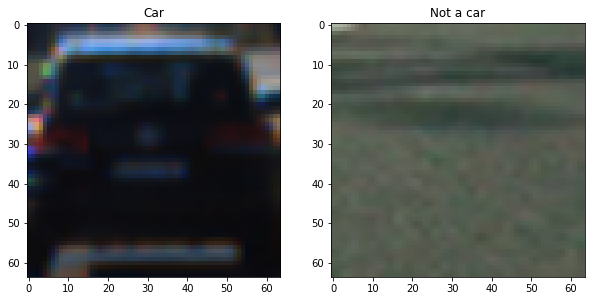

In [2]:
cars = glob.glob('training_data/vehicles/**/*.png')
noncars = glob.glob('training_data/non-vehicles/**/*.png')
# Print length to check the lists are not empty
print('Car images: ',len(cars))
print('Non-car images: ',len(noncars))

# Visualization of one random sample of each label
car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(noncars[np.random.randint(0,len(noncars))])
noncar_img = cv2.cvtColor(noncar_img,cv2.COLOR_BGR2RGB)

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title('Car')
ax[0].imshow(car_img)
ax[1].set_title('Not a car')
ax[1].imshow(noncar_img)

## Method of Histogram of Oriented Gradients (HOG)

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # If hog visualization is true
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

***HOG example visualization***

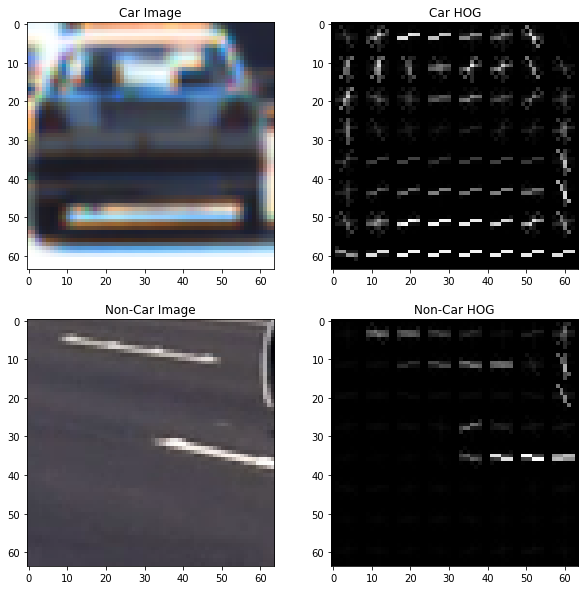

In [4]:
car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
car_img2 =cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
feature_car, car_hog = get_hog_features(car_img2, 9, 8, 8, vis=True, feature_vec=True)

noncar_img = mpimg.imread(noncars[np.random.randint(0,len(noncars))])
noncar_img2 =cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)
feature_noncar, noncar_hog = get_hog_features(noncar_img2, 9, 8, 8, vis=True, feature_vec=True)

f, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(car_img)
ax[0][0].set_title('Car Image')
ax[0][1].imshow(car_hog, cmap='gray')
ax[0][1].set_title('Car HOG')
ax[1][0].imshow(noncar_img)
ax[1][0].set_title('Non-Car Image')
ax[1][1].imshow(noncar_hog, cmap='gray')
ax[1][1].set_title('Non-Car HOG')

## Spatial and color features

In [5]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color_features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return color_features

# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0., 1.)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Extract features from images

In [6]:
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        img_features = []
        # Read in each one by one
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

## Extract features from training dataset images

In [7]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = extract_features(noncars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=False, hist_feat=False, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract the features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - necessary if there is a combination of different features (spatial, color, hog)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Orientations: ', orient)
print('Pixels per cell: ', pix_per_cell)
print('Cells per block: ', cell_per_block)
print('Feature vector length:', len(X_train[0]))

172.97 Seconds to extract the features...
Orientations:  9
Pixels per cell:  8
Cells per block:  2
Feature vector length: 5292


## Train the Classifier

In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For ', n_predict, ' labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For  10  labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00356 Seconds to predict 10 labels with SVC


## Single-image feature extractor

In [9]:
# Function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Sliding Window Search

In [10]:
# Function to find all the slide windows on a given image shape
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Function to search the car in the image
def search_windows(img, windows, svc, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat,hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features) #clf
        #7) If positive (prediction == 1) then save the window
        if prediction >= 0.9:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

***Test image to show search windows***

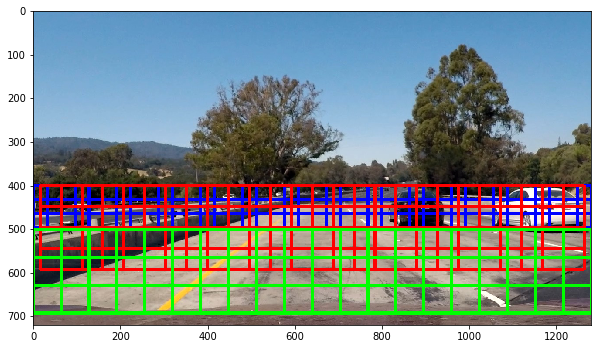

In [11]:
y_area = [[400, 500],
          [400, 600],
          [500, 720]]
x_area = [[0, 1280],
          [16, 1280],
          [0, 1280]]
win_size = [(64, 64),
            (96, 96),
            (128, 128)]
test_img = mpimg.imread('test_images/test1.jpg')
windows = []

windows_f = slide_window(test_img, x_start_stop=x_area[0], y_start_stop=y_area[0], 
                           xy_window=win_size[0],xy_overlap=(0.5, 0.5)) # windows in far range
windows_m = slide_window(test_img, x_start_stop=x_area[1], y_start_stop=y_area[1], 
                           xy_window=win_size[1],xy_overlap=(0.5, 0.5)) # windows in middle range
windows_c = slide_window(test_img, x_start_stop=x_area[2], y_start_stop=y_area[2], 
                           xy_window=win_size[2],xy_overlap=(0.5, 0.5)) # windows in close range

window_img = draw_boxes(test_img, windows_f, color=(0,0,255), thick = 6)
window_img = draw_boxes(window_img, windows_m, color=(255,0,0), thick = 6)
window_img = draw_boxes(window_img, windows_c, color=(0,255,0), thick = 6)
plt.figure(figsize=(10,10))
plt.imshow(window_img)

***Test images to detect vehicles***

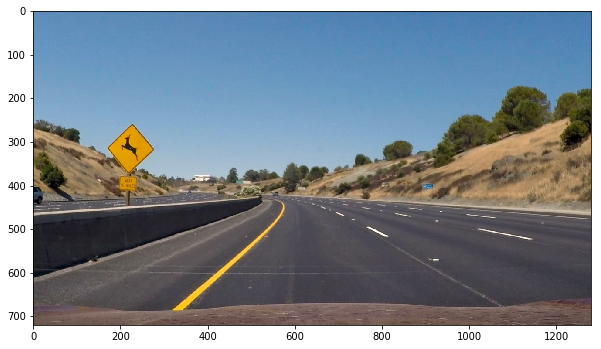

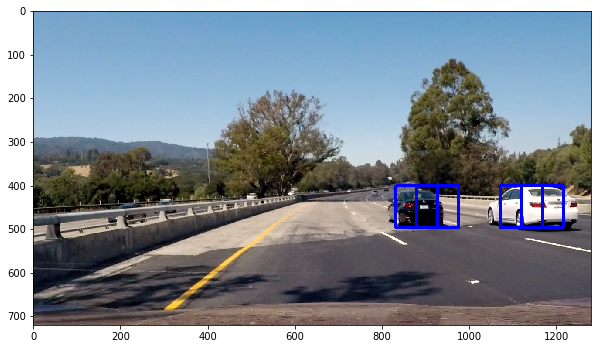

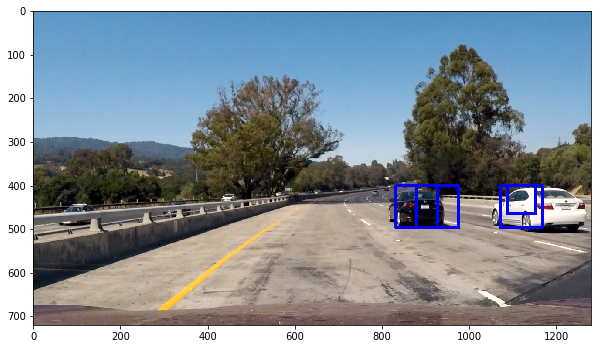

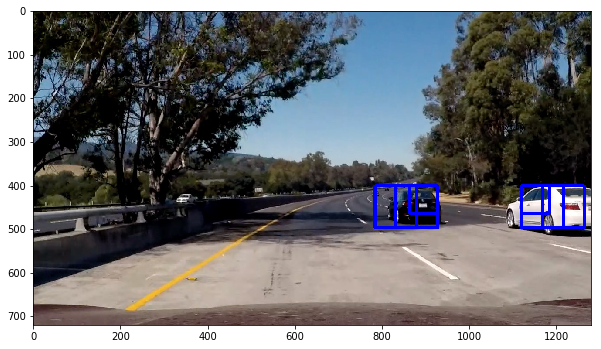

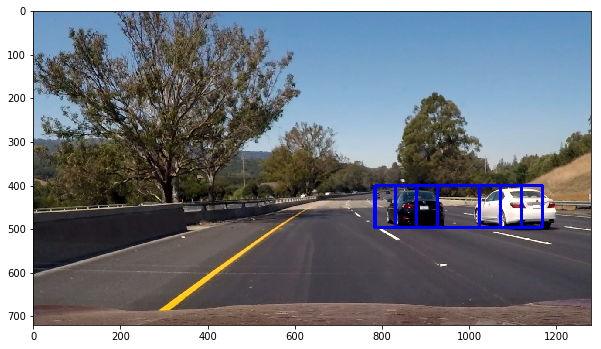

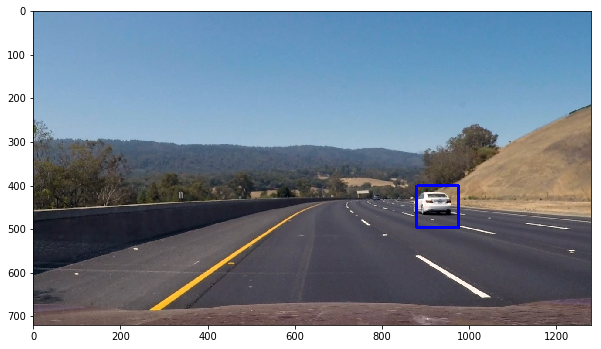

In [12]:
test_imgs = glob.glob('test_images/*.jpg')
for file in test_imgs:
    img = mpimg.imread(file)
    img2 = img.astype(np.float32)/255.0   
    windows = []
    for i in range(len(x_area)):
        windows  += slide_window(img2, x_start_stop=x_area[i], y_start_stop=y_area[i], 
                               xy_window=win_size[i],xy_overlap=(0.5, 0.5))
    on_windows = search_windows(img2, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=False, hist_feat=False, hog_feat=True)
    window_img = draw_boxes(img, on_windows, color=(0,0,255), thick = 6)
    plt.figure(figsize=(10, 10))
    plt.imshow(window_img)

## Multiple Detections and False Positives

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

***Heatmap on test image***

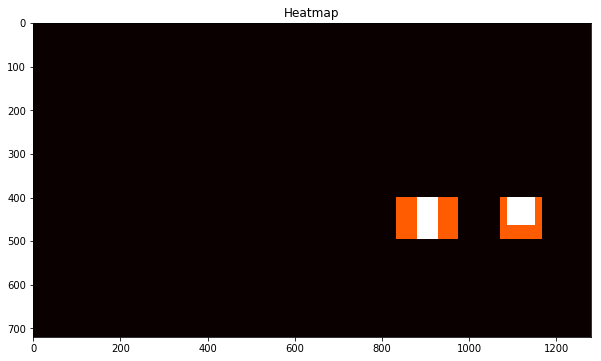

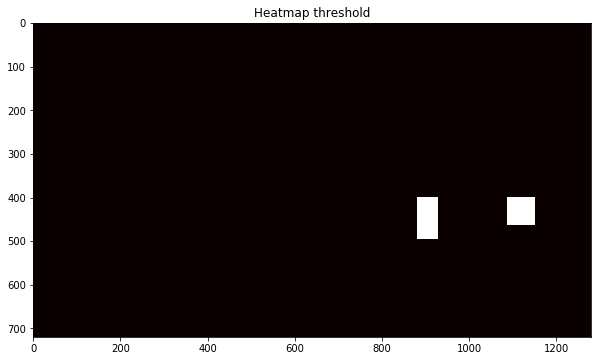

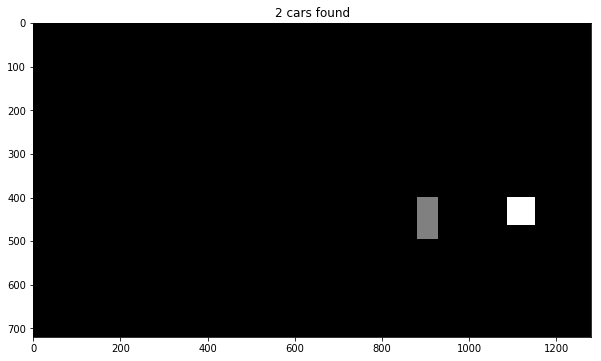

In [14]:
img2 = test_img.astype(np.float32)/255.0   
window_test = []
for i in range(len(x_area)):
    window_test  += slide_window(img2, x_start_stop=x_area[i], y_start_stop=y_area[i], 
                             xy_window=win_size[i],xy_overlap=(0.5, 0.5))
on_windows_test = search_windows(img2, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=False, hist_feat=False, hog_feat=True)

# Heatmap test
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, on_windows_test)
plt.figure(figsize=(10,10))
plt.title('Heatmap')
plt.imshow(heatmap_img, cmap='hot')

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.title('Heatmap threshold')
plt.imshow(heatmap_img, cmap='hot')

# Assign lables to the filtered heatmap
labels = label(heatmap_img)
title = str(labels[1]) + ' cars found'
plt.figure(figsize=(10,10))
plt.title(title)
plt.imshow(labels[0], cmap='gray')

## Draw new boxes based on Thresholded Heatmap

In [15]:
def labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

***Validation on test images***

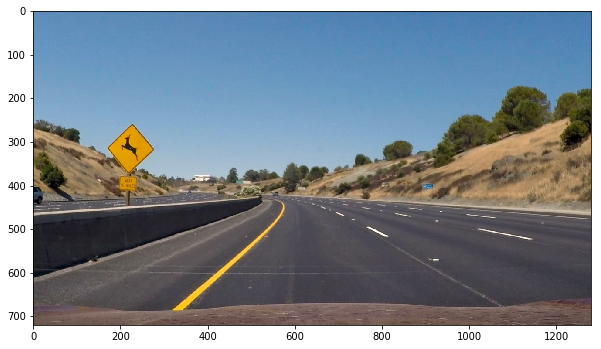

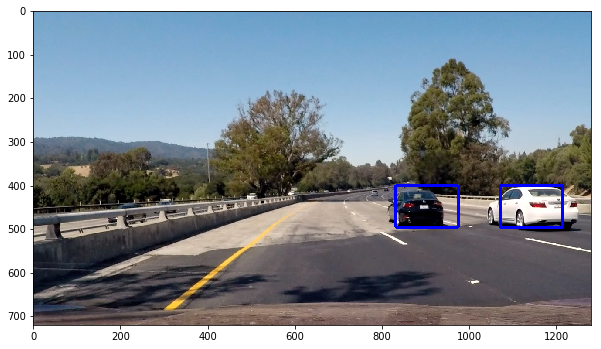

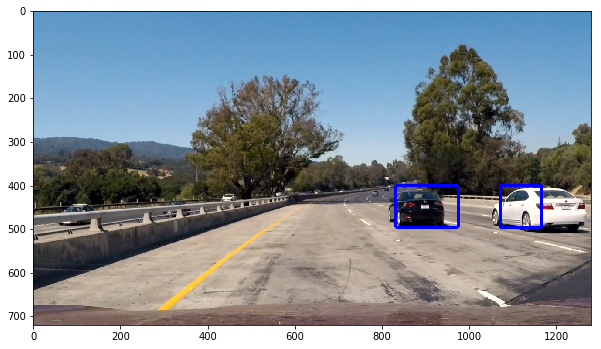

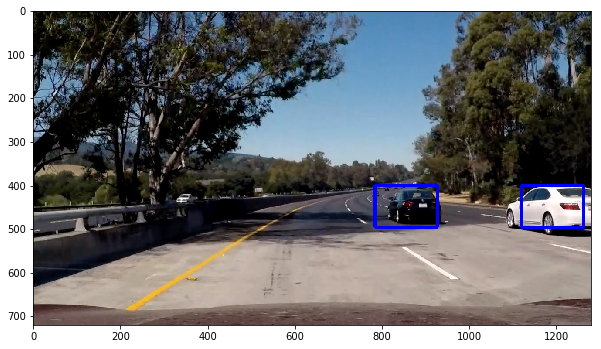

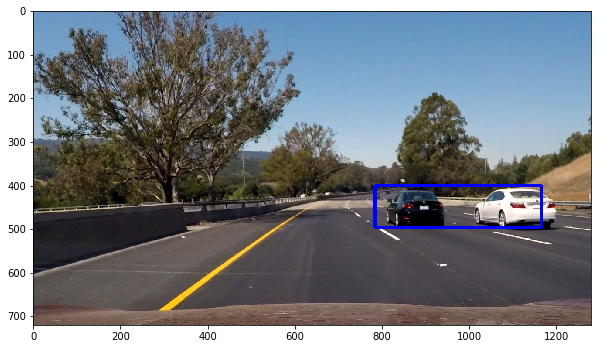

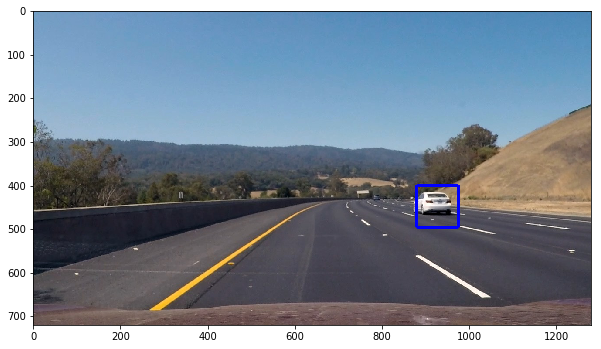

In [16]:
for file in test_imgs:
    img = mpimg.imread(file)
    img2 = img.astype(np.float32)/255.0   
    windows = []
    for i in range(len(x_area)):
        windows  += slide_window(img2, x_start_stop=x_area[i], y_start_stop=y_area[i], 
                               xy_window=win_size[i],xy_overlap=(0.5, 0.5))
    
    on_windows = search_windows(img2, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=False, hist_feat=False, hog_feat=True)
    
    heatmap_img = np.zeros_like(img2[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heatmap_img, on_windows)
    heatmap_img = apply_threshold(heatmap_img, 0.99)
    labels = label(heatmap_img)
    window_img = labeled_bboxes(np.copy(img), labels)
    plt.figure(figsize=(10, 10))
    plt.imshow(window_img)

## Function for Vehicle Detector on Video

In [17]:
def vehicle_detector(img):
    img2 = img.astype(np.float32)/255.0
    y_area = [[400, 500],
              [400, 600],
              [500, 720]]
    x_area = [[0, 1280],
              [16, 1280],
              [0, 1280]]
    win_size = [(64, 64),
                (96, 96),
                (128, 128)]
    
    windows = []
    for i in range(len(x_area)):
        windows  += slide_window(img2, x_start_stop=x_area[i], y_start_stop=y_area[i], 
                               xy_window=win_size[i],xy_overlap=(0.5, 0.5))

    on_windows = search_windows(img2, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=False, hist_feat=False, hog_feat=True)

    heatmap_img = np.zeros_like(img2[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heatmap_img, on_windows)
    heatmap_img = apply_threshold(heatmap_img, 0.99)
    labels = label(heatmap_img)
    window_img = labeled_bboxes(np.copy(img), labels)
    
    return window_img

***Vehicle detector on test video***

In [18]:
video = VideoFileClip('test_video.mp4')
processed_video = video.fl_image(vehicle_detector)
%time processed_video.write_videofile('test_video_output.mp4', audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 35.2 s, sys: 74.2 ms, total: 35.3 s
Wall time: 36.4 s


## Vehicle Detector on Project Video

In [19]:
video = VideoFileClip('project_video.mp4')
project_video = video.fl_image(vehicle_detector)
%time project_video.write_videofile('project_video_output.mp4', audio = False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [19:47<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 19min 43s, sys: 1.8 s, total: 19min 45s
Wall time: 19min 48s
